# IMPORTANT STARTING NOTES

**Code has only been testing on GPU**

In the code immediately below: 
1. Choose how to train - in the code below choose 0, 1 or 2 (optimizing parameters, fully training the model or just gathering training data)
2. Choose paths to training data (leave normal if not appropriate)
3. Choose number of files to generate (leave normal if not appropriate)
4. Choose number of samples per file (leave normal if not appropriate)
5. Choose discriminator parameters (if optimizing parameters fill in multiple rows, otherwize the top row is used to fully train)
6. Choose batch size (if using TPU should be 128 per core otherwise refine to fit memory)
7. Choose number of epochs

In [1]:
train_type = 0
training_paths = ["../input/elevationdataset/elevation_data0(num_samples_ 32).npy"]
num_files = 1
num_samples = 32

discriminator_params = [
    [96,(1,1),(2,2),16,(1,1),(10,10),1,(1,1),(1,1)],
    [96,(1,1),(2,2),32,(1,1),(10,10),1,(1,1),(1,1)],
    [96,(1,1),(2,2),64,(1,1),(10,10),1,(1,1),(1,1)],
    [96,(1,1),(2,2),96,(1,1),(10,10),1,(1,1),(1,1)],
    [96,(1,1),(2,2),112,(1,1),(10,10),1,(1,1),(1,1)],
    [96,(1,1),(2,2),128,(1,1),(10,10),1,(1,1),(1,1)]
]

BATCH_SIZE = 8

EPOCHS = 300

# **Setup**
* *Install dependancies*
* *Import dependancies*
* *Set environment variables*
* *Set mixed precision policy*

## *Install Dependancies*

In [2]:
!pip install imageio
#!pip install git+https://github.com/tensorflow/docs
!pip install elevation
!pip install tensorflow
!pip install matplotlib
!pip install PIL
!pip install shutil

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 24.7 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.1.1
    Uninstalling typing_extensions-4.1.1:
      Successfully uninstalled typing_extensions-4.1.1
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: h5py
    Found existing installation: h5py 3.7.0
    Uninstalling h5py-3.7.0:
      Successfully uninstalled h5py-3.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.10.1
    Uninstalling tensorboard-2.10.1:
      Successfully uninstalled tensorboard-2.10.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are 

## *Import Dependancies*

In [3]:
import tensorflow as tf             #For creating the networks
import glob                         #Something to do with file (probably not necessary and should be removed)
import imageio                      #Somethign to do with images (probably not necessary and should be removed)
import matplotlib.pyplot as plt     #To plot elevation data
import numpy as np                  #To deal with the arrays
import os                           #To change system variables
import PIL                          #To deal with images (specifically reading .tif files)
from tensorflow.keras import layers #To create the network layers

import shutil                       #To zip files (specifically the tensorboard logs)

import datetime                     #Gets the current time and date (secifically to name the logs)

import random                       #Creates random number and arrays to run the networks on
import time                         #Gets the current time (specifically to measure time taken)
import math                         #To run complex caluclation (specifically for calculating lat and long)

from IPython import display         #To clear the output
import elevation                    #To gather elevation data

## *Set Environmental Variables*

In [4]:
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"  #Set GPU to be more memory efficient
print(os.environ.get("TF_GPU_ALLOCATOR"))             #Check system variable has changed

cuda_malloc_async


## *Set Mixed Precision Policy*

In [5]:
#Checks for TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
except ValueError:
    tpu = None

#Gets name of correct policy
if(tpu):
    policyConfig = 'mixed_bfloat16'
else:
    policyConfig = 'mixed_float16'

#Sets Policy
policy = tf.keras.mixed_precision.Policy(policyConfig)
tf.keras.mixed_precision.set_global_policy(policy)

2022-11-05 13:39:51.270742: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-05 13:39:51.412520: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-05 13:39:51.413335: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-05 13:39:51.418128: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


# Setup Necessary Variables

In [6]:
BUFFER_SIZE = 60000 #Unsure what this does

noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier) to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

2022-11-05 13:39:51.469553: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-05 13:39:51.469903: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-05 13:39:51.470594: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-05 13:39:51.471314: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

# Collect Training Data
* *Download elevation data*
* *Read pre-downloaded elevation data*

In [7]:
if(train_type == 2):
    #Function to download new elevation
    def get_elevation(num_samples):   #Num_sampels - number of elevation arrays to generate
      global save_num  #Used to create file name
      num_samples_start = num_samples #Used to record and print current elevation (so you can see where it is up to)
      elevation_data = []  #Array to hold all elevation samples

      while(num_samples > 0): #Loop to download correct number of samples
        try:  #Try statement to stop faulty or missing elevation data (common occurance) from crashing entire program
          #Top lat long cordinates
          East1 = random.uniform(-180, 180)
          North1 = random.uniform(-90, 90)

          #Calculating lat coordinate 20km from previous
          latitude_difference = 20/111.1945
          North2 = North1 + latitude_difference

          #Calculating long coordinate 20km from previous
          longitute_difference = 20 / (111.1945 * math.cos(math.radians(North2)))
          East2 = East1 + longitute_difference

          #Gather elevation data as tif
          elevation_tif = elevation.clip(bounds=(East1, North1, East2, North2), output="/content/tmp.tif")

          elevation_im = PIL.Image.open("/content/tmp.tif") #Read .tif elevation file
          elevation_im = elevation_im.resize((644,644))     #Resize elevation data to match others
          elevation_np = np.array(elevation_im)             #Convert data to numpy array for easier storage and manipulation

          elevation_data.append(elevation_np)  #Append to other samples

          num_samples -= 1


        except:
          print("Exception")

      elevation_data = np.array(elevation_data) #Convert to numpy array
      np.save("/content/elevation_data" + str(save_num) + "(num_samples: " + str(num_samples_start) + ")", elevation_data) #Save numpy array for later use
      save_num += 1

      #Proccess numpy array into tensor
      elevation_data = elevation_data.reshape(elevation_data.shape[0], elevation_data.shape[1], elevation_data.shape[2], 1).astype('float32')
      tf.convert_to_tensor(elevation_data)
      elevation_dataset = tf.data.Dataset.from_tensor_slices(elevation_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

      return elevation_dataset

In [8]:
if(train_type < 2):
    def load_elevation(paths):
      elevation_data = np.load(paths[0])
      first = True
      for path in paths:
        if(first != True):
          elevation_data = np.append(elevation_data, np.load(path), 0)
        first = False

      elevation_data = elevation_data.reshape(elevation_data.shape[0], elevation_data.shape[1], elevation_data.shape[2], 1).astype('float32')

      tf.convert_to_tensor(elevation_data)
      elevation_dataset = tf.data.Dataset.from_tensor_slices(elevation_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

      return elevation_dataset

# Create GAN
* *Define and create generator*
* *Define and create discriminator*
* *Define training loop*

In [9]:
#Function to define generator network
def make_generator_model():
    #Input layer which will take a random array
    model = tf.keras.Sequential()
    model.add(layers.Dense(23*23*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((23, 23, 256)))
    assert model.output_shape == (None, 23, 23, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (3, 3), strides=(28, 28), padding='same', use_bias=False))
    assert model.output_shape == (None, 644, 644, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(16, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 644, 644, 16)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 644, 644, 1)
    
    model.add(layers.Activation("linear", dtype=tf.float32))

    return model

In [10]:
'''generator = make_generator_model()    #Create generator network


#Test the network with a random array
noise = tf.random.normal([1, 100])  #Create random array
generated_image = generator(noise, training=False)   #Use generator with random array

plt.imshow(generated_image[0, :, :, 0], cmap='gray')  #Plot (show) generated image'''

"generator = make_generator_model()    #Create generator network\n\n\n#Test the network with a random array\nnoise = tf.random.normal([1, 100])  #Create random array\ngenerated_image = generator(noise, training=False)   #Use generator with random array\n\nplt.imshow(generated_image[0, :, :, 0], cmap='gray')  #Plot (show) generated image"

In [11]:
#Function to define discriminator model (controlled with variables)
def make_variable_discriminator_model(var1, var2, var3, var4, var5, var6, var7, var8, var9):
    #Input layer takes real or fake elevation data
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(var1, var2, strides=var3, padding='same',
                                     input_shape=[644, 644, 1]))
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(var4, var5, strides=var6, padding='same',
                                     input_shape=[644, 644, var1]))
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(var7, var8, strides=var9, padding='same',
                                     input_shape=[644, 644, var4]))
    model.add(layers.LeakyReLU())

    #Output layer has one neuron with output between 0 and 1 (using sigmoid activation)
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation=tf.keras.activations.sigmoid))
    
    model.add(layers.Activation("linear", dtype=tf.float32))

    return model

In [12]:
'''#Create discriminator
discriminator = make_discriminator_model()

#Test the discriminator on previously generated image
decision = discriminator(generated_image)
print (decision)'''

'#Create discriminator\ndiscriminator = make_discriminator_model()\n\n#Test the discriminator on previously generated image\ndecision = discriminator(generated_image)\nprint (decision)'

In [13]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adamax(1e-4)
generator_optimizer = tf.keras.mixed_precision.LossScaleOptimizer(generator_optimizer)

discriminator_optimizer = tf.keras.optimizers.Adamax(1e-4)
discriminator_optimizer = tf.keras.mixed_precision.LossScaleOptimizer(discriminator_optimizer)

'''checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = None'''

# Define our metrics
if(tpu == None):
    train_disc_real_loss = tf.keras.metrics.Mean('train_disc_real_loss', dtype=tf.float32)
    train_disc_real_accuracy = tf.keras.metrics.MeanSquaredError('train_disc_real_accuracy')

    train_disc_fake_loss = tf.keras.metrics.Mean('train_disc_fake_loss', dtype=tf.float32)
    train_disc_fake_accuracy = tf.keras.metrics.MeanSquaredError('train_disc_fake_accuracy')

    train_gen_loss = tf.keras.metrics.Mean('train_gen_loss', dtype=tf.float32)
    train_gen_accuracy = tf.keras.metrics.MeanSquaredError('train_gen_accuracy')

run_num = 1


def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(predictions[i, :, :, 0])
    plt.axis('off')

  #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()
    
Epoch_offset = 0

# Training Network

**Single Train**

In [14]:
if(train_type == 1):
    @tf.function
    def train_step(images, generator_model, discriminator_model):
        noise = tf.random.normal([BATCH_SIZE, noise_dim])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = generator_model(noise, training=True)

            real_output = discriminator_model(images, training=True)
            fake_output = discriminator_model(generated_images, training=True)

            gen_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)

            scaled_gen_loss = generator_optimizer.get_scaled_loss(gen_loss)
            scaled_disc_loss = discriminator_optimizer.get_scaled_loss(disc_loss)

            #Tensorboard Logs
            if(tpu==None):
                train_disc_real_loss(cross_entropy(tf.ones_like(real_output), real_output))
                train_disc_real_accuracy(tf.ones_like(real_output), real_output)

                train_disc_fake_loss(cross_entropy(tf.zeros_like(fake_output), fake_output))
                train_disc_fake_accuracy(tf.zeros_like(fake_output), fake_output)

                train_gen_loss(gen_loss)
                train_gen_accuracy(tf.ones_like(fake_output), fake_output)

        scaled_gradients_of_generator = gen_tape.gradient(scaled_gen_loss, generator_model.trainable_variables)
        scaled_gradients_of_discriminator = disc_tape.gradient(scaled_disc_loss, discriminator_model.trainable_variables)

        gradients_of_generator = generator_optimizer.get_unscaled_gradients(scaled_gradients_of_generator)
        gradients_of_discriminator = discriminator_optimizer.get_unscaled_gradients(scaled_gradients_of_discriminator)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator_model.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator_model.trainable_variables))
    #####END FUNCTION#####

    #####TRAIN FUNCTION#####
    def train(dataset, epochs, zip_after, generator_model, discriminator_model):
        if(tpu==None):
            current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
            train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
            test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
            train_summary_writer = tf.summary.create_file_writer(train_log_dir)
            test_summary_writer = tf.summary.create_file_writer(test_log_dir)

        for epoch in range(epochs):
            start = time.time()

            for image_batch in dataset:
                train_step(image_batch, generator_model, discriminator_model)

            if(tpu==None):
                with train_summary_writer.as_default():
                    tf.summary.scalar('train_disc_real_loss:', train_disc_real_loss.result(), step=epoch+Epoch_offset)
                    tf.summary.scalar('train_disc_real_accuracy:', train_disc_real_accuracy.result(), step=epoch+Epoch_offset)

                    tf.summary.scalar('train_disc_fake_loss:', train_disc_fake_loss.result(), step=epoch+Epoch_offset)
                    tf.summary.scalar('train_disc_fake_accuracy:', train_disc_fake_accuracy.result(), step=epoch+Epoch_offset)

                    tf.summary.scalar('train_gen_loss:', train_gen_loss.result(), step=epoch+Epoch_offset)
                    tf.summary.scalar('train_gen_accuracy:', train_gen_accuracy.result(), step=epoch+Epoch_offset)

            # Produce images for the GIF as you go
            display.clear_output(wait=True)
            generate_and_save_images(generator_model,
                                     epoch + 1,
                                     seed)

            # Save the model every 15 epochs
            '''if (epoch + 1) % 15 == 0:
              checkpoint.save(file_prefix = checkpoint_prefix)'''

            if (epoch + 1) % zip_after == 0:
                shutil.make_archive("logs", "zip", "logs")

            print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))


        #Reset tensorboard writers
        if(tpu==None):
            train_disc_real_loss.reset_states()
            train_disc_real_accuracy.reset_states()

            train_disc_fake_loss.reset_states()
            train_disc_fake_accuracy.reset_states()

            train_gen_loss.reset_states()
            train_gen_accuracy.reset_states()

      # Generate after the final epoch
        display.clear_output(wait=True)
        generate_and_save_images(generator_model,
                                   epochs,
                                   seed)
    ####END FUNCTION####

    gen_model = make_generator_model()    #Create generator network
    disc_model = make_variable_discriminator_model(discriminator_params[0,0], discriminator_params[0,1], discriminator_params[0,2], discriminator_params[0,3], discriminator_params[0,4], discriminator_params[0,5], discriminator_params[0,6], discriminator_params[0,7], discriminator_params[0,8]) #Create Discriminator
    
    train(load_elevation(training_paths), EPOCHS, 5, gen_model, disc_param)

**Multiple Trains**

In [15]:
if(train_type == 0):
    #Function to train the network on different parameters (easier to identify the best parameters)
    def variable_train(gen_params, disc_params, training_data, num_epochs, zip_after):
        train_num = 0
        for gen_param in gen_params:
            for disc_param in disc_params:
                train_num += 1
                gen_model = make_generator_model()    #Create generator network
                disc_model = make_variable_discriminator_model(disc_param[0], disc_param[1], disc_param[2], disc_param[3], disc_param[4], disc_param[5], disc_param[6], disc_param[7], disc_param[8]) #Create Discriminator

                '''checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     discriminator_optimizer=discriminator_optimizer,
                                     generator=generator,
                                     discriminator=discriminator)'''

                # Notice the use of `tf.function`
                # This annotation causes the function to be "compiled".
                @tf.function
                def train_step(images, generator_model, discriminator_model):
                    noise = tf.random.normal([BATCH_SIZE, noise_dim])

                    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                        generated_images = generator_model(noise, training=True)

                        real_output = discriminator_model(images, training=True)
                        fake_output = discriminator_model(generated_images, training=True)

                        gen_loss = generator_loss(fake_output)
                        disc_loss = discriminator_loss(real_output, fake_output)

                        scaled_gen_loss = generator_optimizer.get_scaled_loss(gen_loss)
                        scaled_disc_loss = discriminator_optimizer.get_scaled_loss(disc_loss)

                        if(tpu==None):
                            #Tensorboard Logs
                            train_disc_real_loss(cross_entropy(tf.ones_like(real_output), real_output))
                            train_disc_real_accuracy(tf.ones_like(real_output), real_output)

                            train_disc_fake_loss(cross_entropy(tf.zeros_like(fake_output), fake_output))
                            train_disc_fake_accuracy(tf.zeros_like(fake_output), fake_output)

                            train_gen_loss(gen_loss)
                            train_gen_accuracy(tf.ones_like(fake_output), fake_output)

                    scaled_gradients_of_generator = gen_tape.gradient(scaled_gen_loss, generator_model.trainable_variables)
                    scaled_gradients_of_discriminator = disc_tape.gradient(scaled_disc_loss, discriminator_model.trainable_variables)

                    gradients_of_generator = generator_optimizer.get_unscaled_gradients(scaled_gradients_of_generator)
                    gradients_of_discriminator = discriminator_optimizer.get_unscaled_gradients(scaled_gradients_of_discriminator)

                    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator_model.trainable_variables))
                    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator_model.trainable_variables))
                #####END FUNCTION#####

                #####TRAIN FUNCTION#####
                def train(dataset, epochs, zip_after, generator_model, discriminator_model):
                    if(tpu==None):
                        current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
                        train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
                        test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
                        train_summary_writer = tf.summary.create_file_writer(train_log_dir)
                        test_summary_writer = tf.summary.create_file_writer(test_log_dir)

                    for epoch in range(epochs):
                        start = time.time()

                        for image_batch in dataset:
                            train_step(image_batch, generator_model, discriminator_model)

                        if(tpu==None):
                            with train_summary_writer.as_default():
                                tf.summary.scalar('train_disc_real_loss:', train_disc_real_loss.result(), step=epoch+Epoch_offset)
                                tf.summary.scalar('train_disc_real_accuracy:', train_disc_real_accuracy.result(), step=epoch+Epoch_offset)

                                tf.summary.scalar('train_disc_fake_loss:', train_disc_fake_loss.result(), step=epoch+Epoch_offset)
                                tf.summary.scalar('train_disc_fake_accuracy:', train_disc_fake_accuracy.result(), step=epoch+Epoch_offset)

                                tf.summary.scalar('train_gen_loss:', train_gen_loss.result(), step=epoch+Epoch_offset)
                                tf.summary.scalar('train_gen_accuracy:', train_gen_accuracy.result(), step=epoch+Epoch_offset)

                        # Produce images for the GIF as you go
                        display.clear_output(wait=True)
                        generate_and_save_images(generator_model,
                                                 epoch + 1,
                                                 seed)

                        # Save the model every 15 epochs
                        '''if (epoch + 1) % 15 == 0:
                          checkpoint.save(file_prefix = checkpoint_prefix)'''

                        if (epoch + 1) % zip_after == 0:
                            shutil.make_archive("logs", "zip", "logs")

                        print ('Train number: {} - Time for epoch {} is {} sec'.format(train_num, epoch + 1, time.time()-start))


                    #Reset tensorboard writers
                    if(tpu==None):
                        train_disc_real_loss.reset_states()
                        train_disc_real_accuracy.reset_states()

                        train_disc_fake_loss.reset_states()
                        train_disc_fake_accuracy.reset_states()

                        train_gen_loss.reset_states()
                        train_gen_accuracy.reset_states()

                  # Generate after the final epoch
                    display.clear_output(wait=True)
                    generate_and_save_images(generator_model,
                                               epochs,
                                               seed)
                ####END FUNCTION####
                train(training_data, num_epochs, zip_after, gen_model, disc_model)

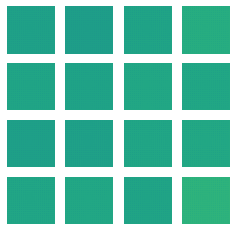

In [16]:
generator_params = [0] #Temporary until I code this to work

variable_train(generator_params, discriminator_params, load_elevation(training_paths), EPOCHS, 5)

# Logging
In order to plot the logs:

**Windows**
1. Download the zip file
2. Extract the zip file
3. Open command line
4. Run command: tensorboard --logdir=logs --host=localhost    *(Where logs is the directory to the unzipped log file)*
5. Open a browser and type in the address bar: localhost:6006